In [1]:
# (C) Copyright IBM Corp. 2019, 2020, 2021, 2022.

#    Licensed under the Apache License, Version 2.0 (the "License");
#    you may not use this file except in compliance with the License.
#    You may obtain a copy of the License at

#           http://www.apache.org/licenses/LICENSE-2.0

#     Unless required by applicable law or agreed to in writing, software
#     distributed under the License is distributed on an "AS IS" BASIS,
#     WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#     See the License for the specific language governing permissions and
#     limitations under the License.


In [17]:
import warnings
import os
import time
with warnings.catch_warnings():
    
    from scipy.integrate import odeint
    import matplotlib.pyplot as plt
    from matplotlib.colors import Normalize
    import numpy as np
    from jax import grad 
    from jax.experimental.ode import odeint as jodeint
    import jax.numpy as jnp
   
    from simulai.regression import OpInf
    from simulai.math.integration import RK4, LSODA, FunctionWrapper, ClassWrapper
    from simulai.metrics import LyapunovUnits
    from simulai.math.differentiation import CollocationDerivative

In [3]:
def NRMSE(exact, approximated):
    return np.sqrt(np.mean(np.square(exact - approximated)/exact.std(axis=0)**2, axis=1))

In [4]:
def NRSE(exact, approximated):
    return np.sqrt(np.square(exact - approximated)/exact.std(axis=0)**2)

In [5]:
save_path = '/tmp'
tol = 0.5
# These are our constants
N = 40 # Number of variables
F = 8  # Forcing
raw_init = False
differentiation = 'spline'

label = f"n_{N}_F_{F}"

if F==8:
    lambda_1 = 1/1.68
else:
    lambda_1 = 1/2.27

In [6]:
def Lorenz96(x, t):
    """Lorenz 96 model with constant forcing"""
    # Setting up vector
    d = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F
    return d

def vec_Lorenz96(x, t):
    """Lorenz 96 model with constant forcing"""
    # Setting up vector
    d = np.zeros((x.shape[0], N))
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[:, i] = (x[:, (i + 1) % N] - x[:, i - 2]) * x[:, i - 1] - x[:, i] + F
    return d

if raw_init is True:
    x0 = F * np.ones(N)  # Initial state (equilibrium)
    x0 += 0.01*np.random.rand(N)  # Add small perturbation to the first variable
else:
    if F==8:
        x0 = np.array([8.00096634, 8.00855744, 8.0092516 , 8.00897888, 8.00354509,
                       8.00481951, 8.00600006, 8.00135191, 8.00400134, 8.00997584,
                       8.00674866, 8.00011935, 8.00281838, 8.00366064, 8.00625296,
                       8.00331608, 8.00622542, 8.00587172, 8.00926064, 8.00749866,
                       8.00911069, 8.0079801 , 8.00504499, 8.00929128, 8.00891238,
                       8.00109078, 8.0012874 , 8.00015617, 8.00651501, 8.00113173,
                       8.00553211, 8.00082682, 8.00055735, 8.00363802, 8.00785242,
                       8.00666548, 8.00107763, 8.0065246 , 8.00785658, 8.00257056])
    else:
        x0 = np.array([8.0099943 , 8.00993294, 8.00835832, 8.00333475, 8.0046541 ,
                       8.00963699, 8.00201772, 8.00456475, 8.00431791, 8.00942586,
                       8.00491029, 8.00894529, 8.00703962, 8.00689952, 8.00276597,
                       8.00547253, 8.00775556, 8.00541117, 8.00597871, 8.00675898,
                       8.00577417, 8.00617584, 8.00147533, 8.00706327, 8.00304462,
                       8.00791486, 8.00205922, 8.00244188, 8.00029354, 8.00977385,
                       8.00584654, 8.009154  , 8.00447355, 8.00386021, 8.00909001,
                       8.00995814, 8.00452692, 8.00634952, 8.00575527, 8.00473347])
    
dt = 0.01
t = np.arange(0.0, 2000.0, dt)
lorenz_data = odeint(Lorenz96, x0, t)[t>=1000]

diff = CollocationDerivative(config={})

if differentiation == "spline":
    derivative_lorenz_data = diff.solve(data=lorenz_data, x=t[t>=1000])
else:
    derivative_lorenz_data = vec_Lorenz96(lorenz_data, t[t>=1000])

Performing Collocation Derivation.


In [7]:
n_steps = t[t>=1000].shape[0]
nt = int(0.5 * n_steps)
nt_test = n_steps - nt
t_test = t[t>=1000][nt:]
n_field = N

In [8]:
train_field = lorenz_data[:nt]  # manufactured nonlinear oscillator data
train_field_derivative = derivative_lorenz_data[:nt]

test_field = lorenz_data[nt:]  # manufactured nonlinear oscillator data
test_field_derivatives = derivative_lorenz_data[nt:]

In [9]:
lorenz_op = OpInf(bias_rescale=1, solver='pinv')
lorenz_op.fit(input_data=train_field, target_data=train_field_derivative)

Forcing terms are not being used.
The data matrices fits in memory.
Fitting process concluded.


In [10]:
print(f"A_hat: {np.array_str(lorenz_op.A_hat, precision=5, suppress_small=True)}")
print(f"H_hat: {np.array_str(lorenz_op.H_hat, precision=5, suppress_small=True)}")
print(f"c_hat: {np.array_str(lorenz_op.c_hat, precision=5, suppress_small=True)}")

A_hat: [[-1.       0.       0.      ... -0.       0.       0.     ]
 [-0.      -0.99999 -0.      ...  0.      -0.       0.     ]
 [ 0.      -0.      -0.99999 ... -0.       0.      -0.     ]
 ...
 [ 0.      -0.       0.      ... -0.99999 -0.       0.     ]
 [ 0.       0.      -0.      ... -0.      -0.99999 -0.     ]
 [-0.       0.      -0.      ...  0.      -0.      -0.99999]]
H_hat: [[-0.  0. -0. ... -0. -1. -0.]
 [-0.  0.  1. ...  0. -0. -0.]
 [-0. -1. -0. ... -0.  0.  0.]
 ...
 [-0.  0.  0. ... -0.  0. -0.]
 [-0.  0.  0. ... -0.  0. -0.]
 [-0.  0.  0. ... -0. -0. -0.]]
c_hat: [[7.99998]
 [8.     ]
 [8.     ]
 [7.99998]
 [7.99997]
 [8.00006]
 [8.00001]
 [8.00001]
 [8.00001]
 [7.99999]
 [8.00001]
 [8.     ]
 [7.99999]
 [7.99997]
 [7.99999]
 [8.     ]
 [8.00001]
 [7.99999]
 [8.     ]
 [7.99999]
 [8.00001]
 [7.99998]
 [8.00001]
 [7.99999]
 [7.99998]
 [8.00002]
 [7.99999]
 [7.99997]
 [8.     ]
 [8.     ]
 [7.99999]
 [8.     ]
 [8.     ]
 [7.99997]
 [7.99998]
 [7.99999]
 [8.00002]
 [7.9999

In [11]:
init_state = train_field[-1:]
estimated_field_derivatives = lorenz_op.eval(input_data=test_field)
tags = [fr'x_{i}' for i in range(n_field)]

Construcing jacobian tensor (It could be used during the time-integrations, but seemingly it is not).

In [12]:
lorenz_op.construct_K_op()

Time-integrating the trained model and visualizing the output.

In [13]:
# Using the derivatives surrogate for time-integrating
right_operator = ClassWrapper(lorenz_op)

solver = LSODA(right_operator)

initial_state = init_state[0]

initial_time = time.time()
estimated_field = solver.run(initial_state, t_test)
elapsed_time = time.time() - initial_time
print(f"Elapsed time for time-integrating: {elapsed_time} s")

Elapsed time for time-integrating: 29.922213554382324 s


Estimating the number of Lyapunov units for the extrapolation.

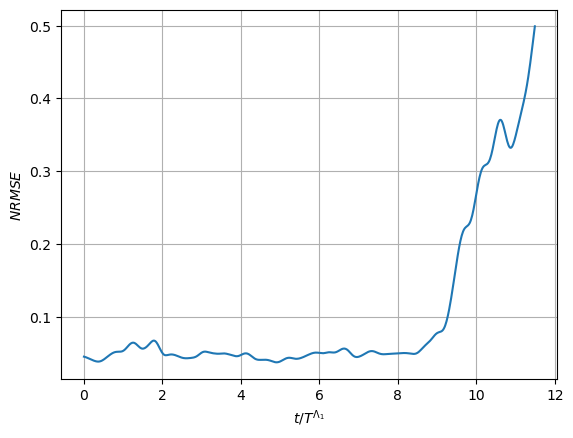

VPT is 11.491199999999862


In [14]:
nrmse = NRMSE(test_field, estimated_field)
nrmse_ = nrmse[nrmse<=tol]

time_ref = (t_test - t_test[0])/lambda_1
t_ref = time_ref[nrmse<=tol]
VPT = t_ref[-1]

plt.plot(t_ref, nrmse_)
plt.ylabel(r"$NRMSE$")
plt.xlabel(r"$t/T^{\Lambda_1}$")
plt.grid(True)
plt.savefig(os.path.join(save_path, f"nmrse_along_time_{label}.png"))
plt.show()

print(f"VPT is {VPT}")

nrse = NRSE(test_field, estimated_field)

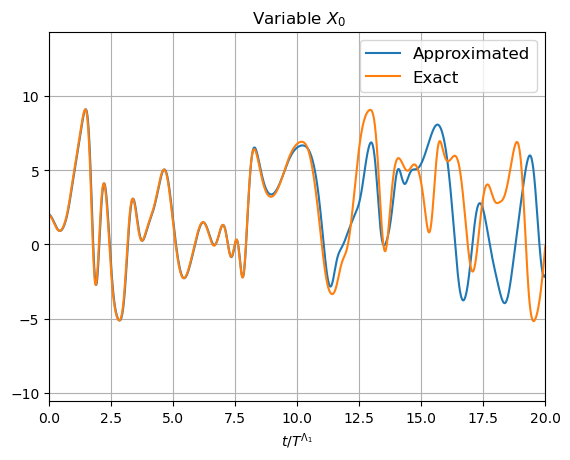

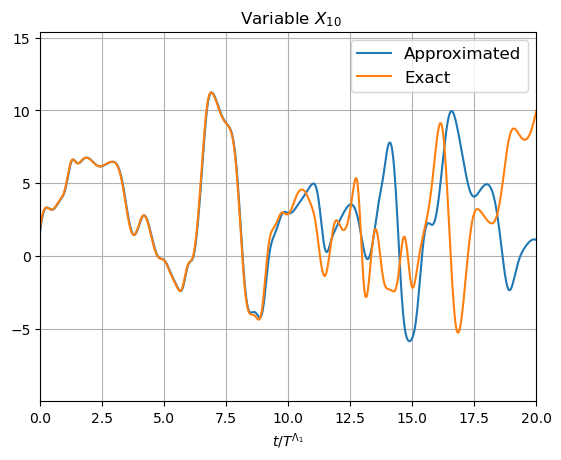

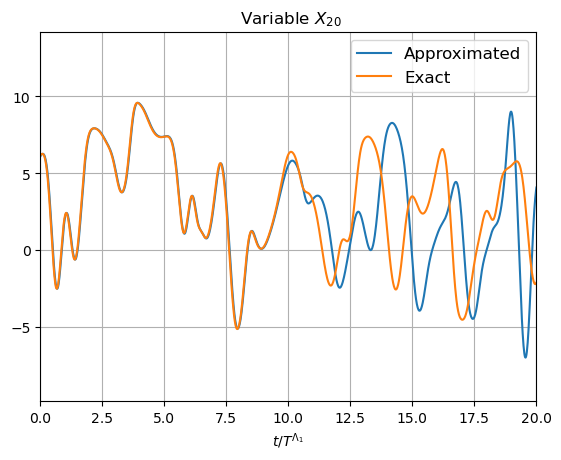

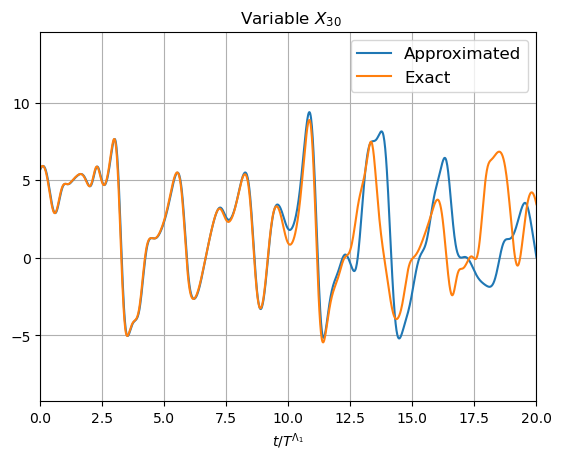

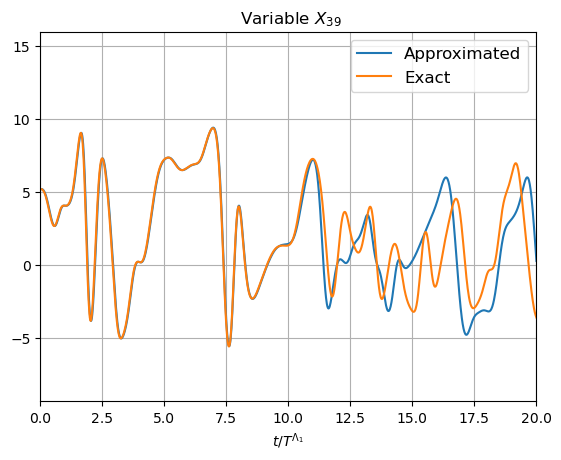

In [15]:
vars = [0, 10, 20, 30, 39]

for vv in vars:
    plt.plot(time_ref, estimated_field[:, vv], label="Approximated")
    plt.plot(time_ref, test_field[:, vv], label="Exact")
    plt.title(rf" Variable $X_{str({vv})}$")
    plt.xlabel(r"$t/T^{\Lambda_1}$")
    plt.xlim(0, 20)
    plt.grid(True)
    plt.legend(fontsize=12.)
    plt.savefig(os.path.join(save_path, f"evaluation_{vv}_{label}"))
    plt.show()

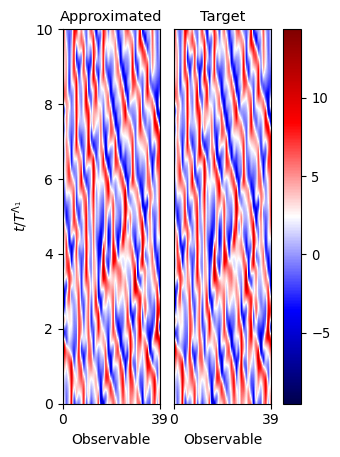

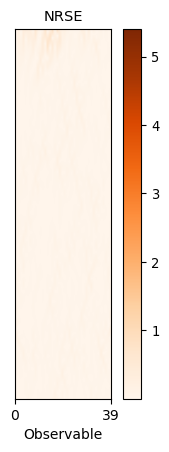

In [16]:
t_plot = time_ref
x_plot = np.arange(0, N)
aspect = 15
extent = x_plot.min(), x_plot.max(), t_plot.min(), t_plot.max()

color_norm = Normalize(vmin=test_field.min(), vmax=test_field.max())

fig, (ax1, ax2) = plt.subplots(ncols=2)

ax1.imshow(np.flip(estimated_field,axis=0), extent=extent, aspect=aspect, cmap='seismic',
           interpolation='bilinear',
           norm=color_norm)

ax1.set_title("Approximated", fontsize=10.5)
ax1.set_xlabel("Observable")
ax1.set_ylabel(r"$t/T^{\Lambda_1}$")
ax1.set_xticks([0, 39])
ax1.set(ylim=(0, 10))

values2 = ax2.imshow(np.flip(test_field, axis=0), extent=extent, aspect=aspect, cmap='seismic',
                    interpolation='bilinear',
                    norm=color_norm)

ax2.set_title("Target", fontsize=10.5)
ax2.set_xlabel("Observable")
ax2.set_xticks([0, 39])
ax2.set_yticks([])
ax2.set(ylim=(0, 10))

cbar1 = fig.colorbar(values2, ax=ax2)
fig.subplots_adjust(wspace=-0.6, bottom=.1, left=0.2, right=.7)

for t in cbar1.ax.get_yticklabels():
     t.set_fontsize(9.5)

plt.savefig(os.path.join(save_path, f"comparison_exact_predicted_2D_plot_{label}.png"))

plt.show()

fig1, ax3 = plt.subplots()
values3 = ax3.imshow(np.flip(nrse, axis=0), extent=extent, aspect=aspect,
           interpolation='bilinear',
           cmap="Oranges"
           )
ax3.set_title("NRSE", fontsize=10.5)
ax3.set_xlabel("Observable")
ax3.set_xticks([0, 39])
ax3.set_yticks([])
ax3.set(ylim=(0, 10))

cbar2 = fig.colorbar(values3, ax=ax3)
fig1.subplots_adjust(wspace=.1, right=0.5, hspace=0)

for t in cbar2.ax.get_yticklabels():
     t.set_fontsize(9.5)
       
plt.savefig(os.path.join(save_path, f"no_number_nrse_2D_plot_{label}.png"))

plt.show()